# Prediction of Youtube Music-Video Views Based on Visual Features.
## Project Description
The aim of this project is to predict the number of views a certain YouTube music video has got only by using the visual information provided by the video itself.  
Thus, relying on metainformation like 'Song Name' or 'Band' as well as the audio coming with the video is strictly forbidden.  
The source code of the project can be accessed [here](https://github.com/AlexRaschl/PR_data_science).
 
The following protocol gives an overview of all the different approaches and steps that have been applied during this project.



## 1: Dataset creation
The first step of this project has been to create a dataset consisting of various YouTube music videos.  
In order to select possible songs to search for we used the song-list from the LFM-1b dataset.
We divided our dataset creation procedure into two steps:
- Extraction: Search and select music videos 
- Download: Download found music videos


### Extraction
#### First Approach
The goal of this step has been to find a way to check if a music video of these songs exist and if yes, 
to download the video from YouTube.  
Already this step was very problematic, as it is very difficult to decide only based on the meta-info of the YouTube search results, if the video is indeed a music 
video for the searched song. How we handled this in detail is described later on.  
Our first attempt to query the songs on YouTube has been to make use of the YouTube-API, which provides 
a very straightforward and easy to use interface for querying information.  
Unfortunately, we had to refrain from using the YouTube API, as it only allowed us to query about 10 songs 
per day, which results in a far too slow search speed of course.   

#### Second Approach
Afterwards, we decided to use a hand crafted crawling approach as an alternative via the use of the Scrapy python package.  
Therefore, we implemented a web-crawler issuing search queries on YouTube for a specific song $X$ and creator $C$ 
using the following search pattern:  
"$X$ - $C$ Official Video"

This already led to very promising results, however, also many false positives were included in the crawled data, 
such as lyric videos, videos of other songs of the same band, and just uploads of the audio with a picture of the CD-Cover.  
In order to decrease our false positive rate, we used the following rules to define our final YouTube database.

##### Extraction Rules
We defined the various rules based on the following video meta-info:
- Title of the Video
- Description of the Video
- Channel name that uploaded the Video

Based on the information above we defined the following rules:  
- If the title contains the words 'Cover' or 'Lyric', we assume that it is not the original music video for the song
- If the name of the band is neither in the Title nor in the Channel name we reject the video
- If "Official video" occurs in the Title or in the Description in various languages and mutations, we accept the video
- If "Full video" occurs in the title, we accept the video
- If "Directed by" occurs in the description, we accept the video
- If the video title exactly matches: "$SongName$ - $Creator$", we accept the video.
- In all other cases, we reject the video. 

These search rules lead to good results, however, there were still many videos dropped, which was not that much of an 
issue as we had plenty of songs to search for.  
So the clear focus has been on finding a consistent database of videos that are really music videos, than on avoiding 
false negatives.  
The only problem, we noticed was that there were still many videos marked as music video that were only showing the 
CD-Cover of the band, whilst playing the audio.  
We will talk about how we fixed this in a later step.  
The result of the crawling step is a MongoDB, storing the LFM-1b data as well as the according found video meta-info 
like *Video-ID*, *title*, *channel*, *description*, and the *URL* to video.


### Download
#### Fetching the Videos
As we had now built a database storing the video-urls to music-videos, the only thing left to do to finalize our 
dataset creation was to download the music videos for the later use in prediction.  
To tackle this, we used the 'youtube-dl' python package, which fortunately also allows to download all the video 
meta-info as json file.  
We used the meta-info for updating our database, to store the needed viewcounts and even more information like 
dislikes, likes, duration and video resolution.  

As we expected to run into memory problems due to the large amount of videos, we decided to crawl videos  with a 
max resolution of *640x360p*.  
The videos are stored on a specified location and the path to the video is stored in the database.


##### Problems
During our Downloading process, we unfortunately had to cope with some restrictions on how fast we can download 
videos, which is possibly caused by a DoS protection configured by YouTube.  
This problem already occurred during the Extraction process, but we were able to solve it via waiting some time 
after a query has been issued.  
However, the Downloading process was putting far more load on YouTube than simply searching for videos.  
Hence, especially the downloading process was very tedious and required long waiting times as well as trying 
different configurations.   
This has certainly eaten a huge amount of valuable time, that could have been put to good use otherwise.  
Thus, we would recommend to directly contact YouTube for extended API access, if someone wants to mine a similar 
dataset again, in order to avoid the mentioned problems. 



## 2: Preprocessing
The previous step resulted in a dataset consisting of about 10500 downloaded music videos including their meta-info.  
In order to make predictions on how we want to predict the viewcounts we had to solve the following issues:
- How do we handle the huge amount of video data (~200 Gb)?
- What features should we extract and how?


##### Size of Data
Regarding the memory problem, we took a similar approach as Yu-Gang Jiang et al. in ["Understanding and Predicting 
Interestingness of Videos"](https://www.aaai.org/ocs/index.php/AAAI/AAAI13/paper/viewPaper/6230).   

In order to extract visual features, we sampled frames from the video in equally 
spaced intervals.  
As a result, each video is described via a fixed amount of frames *N*.  
During this process we had a very interesting idea in order to reduce our false-positive rate among the selected 
music videos.  
As we mentioned earlier, our video extraction pipeline still included many "music videos", only showing 
an album cover, whilst playing the audio.  
In order to detect that, we used Structural-Similarity Scores between two consecutively sampled frames in order to 
check if they are basically the same.  
If the number of equal frames in a video exceeds a certain threshold, we exclude 
the video from the music video dataset and delete it to free storage space.  
This filtering was definitely a huge improvement to our database and is perfectly embedded into the video subsampling 
step anyways.


##### Features to Extract
In order to decide on the features to use for our regression task, we looked at various resources published by the 
scientific community, especially publications from the MediaEval challenge.  
The most promising publication regarding related work has been in our opinion: ["Predicting popularity of online videos 
using Support Vector Regression"](https://ieeexplore.ieee.org/abstract/document/7903630/) by Tomasz Trzcinski and Przemysław Rokita..  
They listed a huge amount of various features, which they used in order to predict the viewcounts of Facebook and 
YouTube videos.  
At first they extracted basic video characteristics such as length, frame rate and resolution.  
Furthermore, they extracted basic color information encoding the most dominant color in a frame.  
Another approach has been to extract occurrences of faces and their relative size in the frame.  
They applied OCR as well to spot subtitles and other textual hints.  
Their most promising approach was to use a CNN pretrained on ImageNet in order to get an idea of what happens actually 
in the video.  
Therefore, they extracted a set of frames that should represent the video scenes and propagated these through the CNN.  
They averaged the resulting 1000 dimensional probability vector and normalized the result to 1.  

However, the term most promising should be taken with a grain of salt as the reported correlation coefficients for all 
of the visual features are fairly low. 

In general, we noticed the problem that we could not find literature on how to predict video popularity solely based 
on visual features.  
In the mentioned work the task was to predict the viewcounts for the 30th day given the viewcount history of the 
preceding 29 days.  
The described visual features were basically only used as a hint for finetuning of the regression results. 

In other works they mostly used audio and visual features in combination with meta-data in order to get useful results, 
which is of course not the goal of our task.


As the mentioned CNN approach showed the most promising results in their research, we started with implementing this 
for our project as well.  
Furthermore, we used basic video information such as length, color information and also a face detector to retrieve features.
This process is described in detail in the following parts. 


##### Feature Extraction
Foremost, we implemented a small class performing a clean Train-Test Split for splitting our dataset into test and train sets. 
Our feature extractors are used on both sets separately.

At first we built an image classifier, which should predict what is happening in each sampled video frame.  
Therefore, we used the *ResNet50* CNN loaded with weights pretrained on the [Imagenet](http://www.image-net.org/) challenge.  
This results in a 1000 dimensional probability vector, describing the probability of each of the 1000 ImageNet classes 
to occur.  
Out of these probabilities we store the top-5 predictions to serve as features for the specific image.  
Thus, we end up with 5 labels per sampled image and their respective probabilities for all the sampled images of a video.  
We also implemented the approach of Tomasz Trzcinski and Przemysław Rokita via averaging the 1000 dimensional 
probability vector over all images of a video and storing the normalized vector as features for later regression analysis, 
which we later found out work better.  
As a result, we end up with having two slightly different kinds of CNN based visual features for regression later on.

Afterwards we built a small feature extractor, which should count the occurrences of faces in the sampled video frames. 
The extracted features are:
- The total number of faces in the video samples
- The average number of faces per frame
- The average percentage of image-space covered by faces. 

At last, we wanted to extract some low level color information. Therefore, we loaded the video frames and converted 
them to HSV-Color space for easy color picking.  
We split the color space into 9 different 'main' colors being: red, orange, yellow, green, cyan, blue, violet, pink, 
black and white.  
For every frame we store the most dominant color as well as the most dominant color of the video overall. 

As the 1000 dimensional vector of the CNN predictions and the 9 different colors are categorical features, 
we provide functionality to load them in one-hot-encoded manner during regression.

To sum up, the following features are now available for each video:
- Basic
    - Video duration in seconds
- CNN based
    - Top 5 labels/probabilities for every frame
    - Normalized average 1000 dimensional probability vector of label occurrence
- Faces
    - The total number of faces in the video samples
    - The average number of faces per frame
    - The average percentage of image-space covered by faces
- Color
    - Most dominant color per frame in video
    - Most dominant color per video

## 3: Exploratory Data Analysis
Before we actually start with trying to fit a regression model to the data, we wanted at first to get a general 
overview of how the video dataset actually looks like with respect to the distribution of the viewcounts, likes and dislikes.

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import src.eda.eda_util as eda_util
from src.preprocessing.indexer import Indexer

import os
%pwd
%matplotlib inline

In [2]:
WDIR = os.getcwd()
os.chdir(WDIR+'\\..\\..')

In [3]:
# Fetch the data
X_train, X_test, y_train, y_test = Indexer.load_split('cache/tts_42')
df = X_train.append(X_test)
y = y_train.append(y_test)
df = eda_util.get_metaframe(df)
df.rename(columns={0: 'v_id', 1: 'n_samples'}, inplace=True)  # Backwards compatibility
df['viewcounts'] = y

# Replacing NaN's with 0 as these videos have 0 likes/dislikes
df.fillna(value=0, inplace=True) 



### General Overview

At first, let us look at some sample rows:

In [4]:
# Showing some sample rows
df.head()



,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
9323,P6wJiweByng,30,299,Stop Coming to My House,Mogwai,1240.0,26.0,4.917851,292400
4969,yqkamXgTjF4,30,180,Хамелеон,Lumen,23.0,0.0,5.000000,3937
4789,PZuLsz4yPPM,30,239,Breathing Underwater,Metric,19918.0,407.0,4.919901,3201230
2673,mVObfpaR2_I,30,248,Thugz Mansion,2Pac,86034.0,2608.0,4.882313,12454780
8267,m4tJSn0QtME,30,222,Long Train Running,The Doobie Brothers,77237.0,3214.0,4.840201,13226400


Afterwards, we compute some summary statistics of the data:

In [5]:
# Compute summary statistics
df.describe()

,n_samples,v_duration,v_likes,v_dislikes,v_avg_rating,viewcounts
count,10383.0,10383.000000,1.038300e+04,1.038300e+04,10383.000000,1.038300e+04
mean,30.0,253.659540,1.736993e+05,7.550843e+03,4.882782,3.527945e+07
std,0.0,116.590743,6.263650e+05,4.332213e+04,0.128684,1.348261e+08
min,30.0,35.000000,0.000000e+00,0.000000e+00,0.000000,2.100000e+01
25%,30.0,209.000000,1.512000e+03,3.200000e+01,4.865543,2.180730e+05
50%,30.0,238.000000,1.170700e+04,2.850000e+02,4.904043,2.024567e+06
75%,30.0,276.000000,7.367900e+04,2.108500e+03,4.932036,1.375550e+07
max,30.0,4478.000000,1.200607e+07,1.555113e+06,5.000000,2.953195e+09


### Viewcounts
The viewcounts of all videos are inspected in this part, in order to get a feeling 
how the viewcounts of music-videos of all genres are distributed:

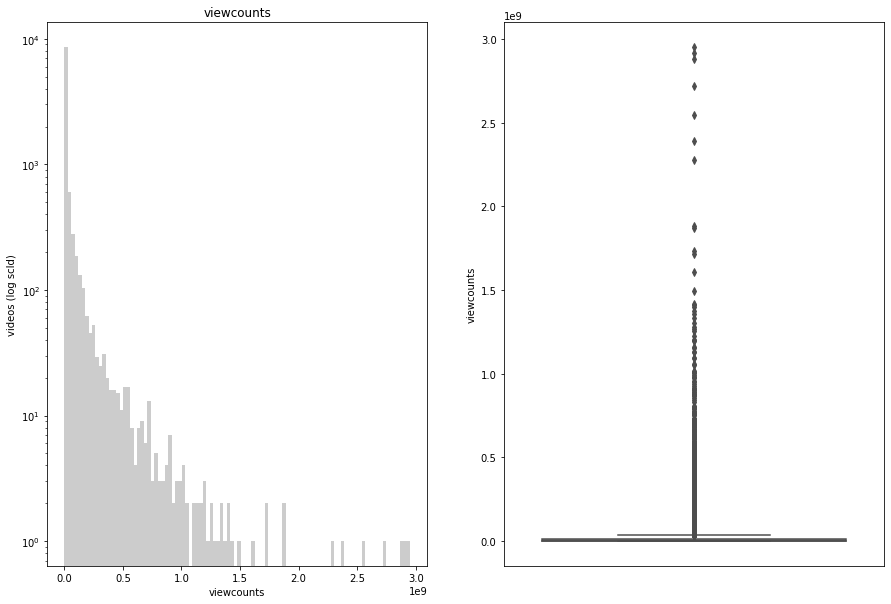

In [6]:
def plot_attribute(df, key: str, scale: str ='linear', color:str='grey', 
                   figsize:tuple=(15,10), kde: bool =False):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=figsize)
    ax[0].set(yscale=scale)
    sns.distplot(df[key].to_numpy(), bins=100, color=color, kde=kde, ax=ax[0])
    ax[0].set_title(key)
    ax[0].set_xlabel(key)
    ax[0].set_ylabel('videos' if scale is 'linear' else 'videos (log scld)')
    
    sns.boxplot(data=df[key].to_numpy(), color=color, ax=ax[1])
    ax[1].set_ylabel(key)
    ax[1].set_xticks([])
    plt.show()
    
plot_attribute(df,'viewcounts', 'log')

When looking at the histogram describing the viewcount distribution it looks like an 
exponential distribution.  
We also want to remark that the y-scale of the histogram is logarithmic, 
as otherwise we would only encounter a peak at 0.  
Furthermore, the boxplot on the right shows that approximately $75$% of the videos in the dataset have viewcounts between
approximately 350k and 13kk views.  
Also there are many outliers and extremal points towards 3 billion views.  
As a result, it can be said that there is a majority of less viewed or less popular music-videos in the dataset mixed 
with a few very popular videos.  
The overall distribution of the views seems to behave exponential. 

#### Least viewed
In the following we look at the least viewed videos:

In [7]:
sorted_views = df.sort_values(by=['viewcounts'], ascending=True)
sorted_views.head()

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
45,-FeCW1JfnCE,30,82,Future Past,Geneva Jacuzzi,4.0,0.0,5.0,21
1174,7SgI_9u9A9c,30,172,В наших глазах,Кино,4.0,0.0,5.0,42
995,EGGbzLspma4,30,116,His Name Is Mutty Ranks,A Tribe Called Quest,1.0,0.0,5.0,85
7682,vURmrSGntcw,30,249,Живое,Flёur,2.0,0.0,5.0,87
4682,UjiWLgdFICs,30,225,A Shot In the Dark,A Day to Remember,2.0,0.0,5.0,87


#### Most viewed
Furthermore, we also get a peek on the most viewed videos:

In [8]:
sorted_views.tail()[::-1]

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
1224,CevxZvSJLk8,30,269,Roar,Katy Perry,10337849.0,834301.0,4.701293,2953194541
3954,hT_nvWreIhg,30,283,Counting Stars,OneRepublic,10910764.0,379936.0,4.865398,2916274115
2611,lp-EO5I60KA,30,297,Thinking Out Loud,Ed Sheeran,10733276.0,480611.0,4.828566,2878210876
4381,0KSOMA3QBU0,30,225,Dark Horse,Katy Perry,9700774.0,1112115.0,4.588596,2721476508
719,RBumgq5yVrA,30,254,Let Her Go,Passenger,9722598.0,325193.0,4.870542,2546728867


### Likes
The next step is to look on how the likes of the music videos are distributed:

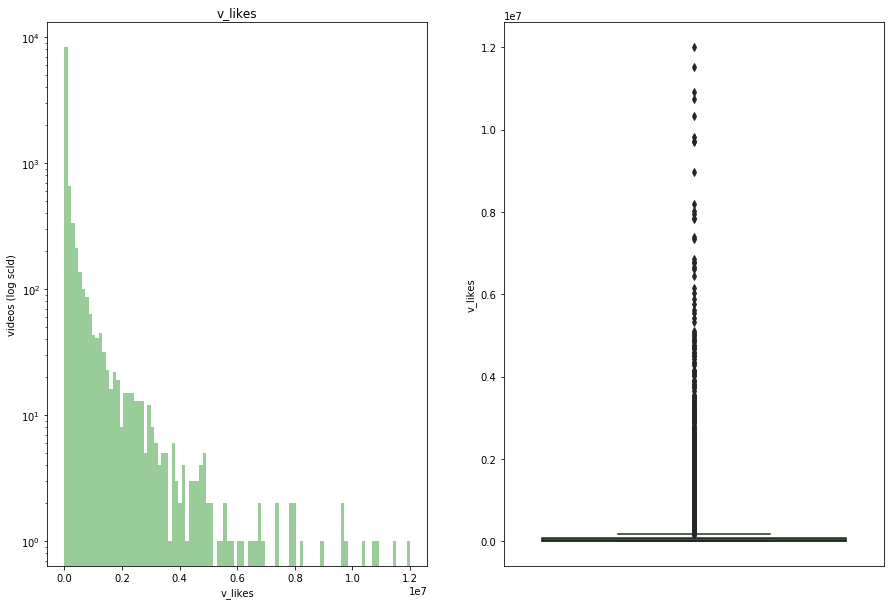

In [9]:
plot_attribute(df,'v_likes', 'log', color='green')

Their distribution seems to be fairly equal to the distribution of the views also 
suggesting an underlying exponential distribution.  
Please also note that the y-axis is log-scaled.

#### Least liked
In the following we look at the least liked videos:

In [10]:
sorted_likes = df.sort_values(by=['v_likes'], ascending=True)
sorted_likes.head()

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
4508,HbSvs8VZStE,30,330,On the Wing,Owl City,0.0,0.0,4.936663,740940
9813,911GFmPGJcI,30,162,Les métamorphoses du vide,Chapelier Fou,0.0,0.0,4.946667,30824
5065,ovox258unME,30,236,Jerusalem,Anouk,0.0,0.0,4.815974,734380
2818,mqhkyQ6bP6A,30,284,Roland,Interpol,0.0,0.0,4.932039,28591
1877,W5FfJ89rGPc,30,222,Why Can't We Be Friends?,War,0.0,0.0,4.924011,3221211


#### Most liked
Furthermore, we also get a peek on the most liked videos:

In [11]:
sorted_likes.tail()[::-1]

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
4141,2Vv-BfVoq4g,30,280,This,Ed Sheeran,12006069.0,475809.0,4.847520,2278056368
2252,XbGs_qK2PQA,30,369,Rap God,Eminem,11524278.0,384222.0,4.870942,979811289
3954,hT_nvWreIhg,30,283,Counting Stars,OneRepublic,10910764.0,379936.0,4.865398,2916274115
2611,lp-EO5I60KA,30,297,Thinking Out Loud,Ed Sheeran,10733276.0,480611.0,4.828566,2878210876
1224,CevxZvSJLk8,30,269,Roar,Katy Perry,10337849.0,834301.0,4.701293,2953194541


### Dislikes
Same as for the likes and views we now inspect the dislikes.  
Just as it is the case for the likes and views they follow an exponential distribution, but compared to the like counts it appears to decline faster.  
Thus, we can say that there are not as many videos with high dislike counts as there are videos 
with high like counts.  
As a result, either people who dislike a video tend to not hit the dislike button or the overall quality of the videos is high.  
Most likely the second assumption is more probable, as there are mostly musicvideos made for more popular bands/song-creators. 

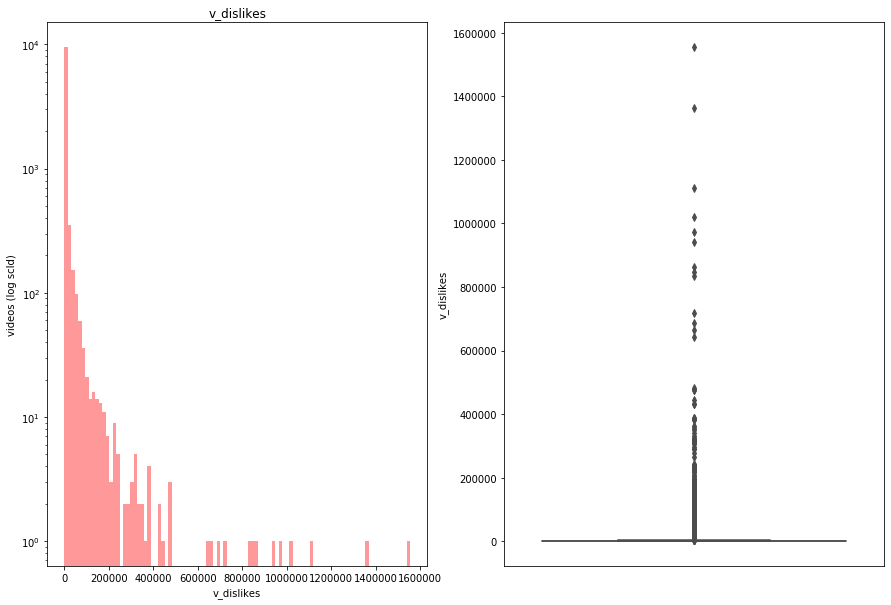

In [12]:
plot_attribute(df,'v_dislikes', 'log', color='red')

#### Least dislikes
In the following we look at the least disliked videos:

In [13]:
sorted_dislikes = df.sort_values(by=['v_dislikes'], ascending=True)
sorted_dislikes.head()

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
7230,HlN9jY-yyuA,30,217,Architecture of Aggression,Megadeth,29.0,0.0,5.0,2146
569,WZHA7GCX-Nk,30,84,A Very Respectable Hobbit,Howard Shore,13.0,0.0,5.0,1023
2292,2O6kPgeMurE,30,142,The Attic,Paul Weller,58.0,0.0,5.0,10020
8319,ZgyuIwa832Y,30,174,Chump,Green Day,5.0,0.0,5.0,352
4620,rXllND_LRf0,30,259,The Last Polka,Ben Folds Five,197.0,0.0,5.0,16404


#### Most dislikes
Furthermore, we inspect the videos with the most dislikes:

In [14]:
sorted_dislikes.tail()[::-1]

,v_id,n_samples,v_duration,song_name,creator,v_likes,v_dislikes,v_avg_rating,viewcounts
2171,My2FRPA3Gf8,30,221,Wrecking Ball,Miley Cyrus,5419945.0,1555113.0,4.108186,1055364657
2043,LrUvu1mlWco,30,213,We Can't Stop,Miley Cyrus,3772655.0,1363910.0,3.937882,875538230
4381,0KSOMA3QBU0,30,225,Dark Horse,Katy Perry,9700774.0,1112115.0,4.588596,2721476508
1091,4GuqB1BQVr4,30,211,Boyfriend,Justin Bieber,4509750.0,1020224.0,4.262041,772678855
7537,T6j4f8cHBIM,30,210,Stupid Hoe,Nicki Minaj,816041.0,974259.0,2.823250,116636048


### Average Rating
Furthermore, youtube video metadata provides us with so called average ratings 
of the videos so we will shortly take a look at them:

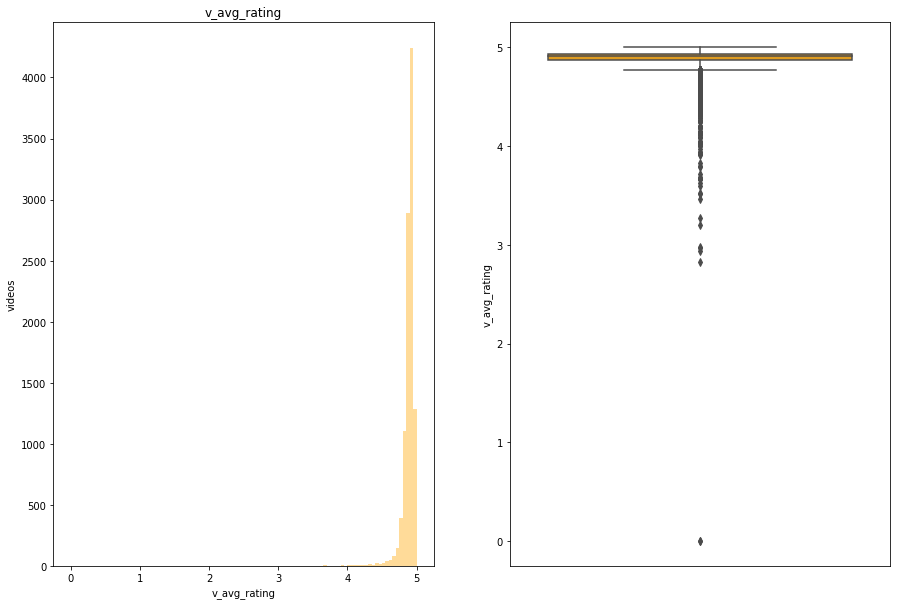

In [15]:
plot_attribute(df,'v_avg_rating', color='orange')

### Connections
At last, we want to check the relations between the different features.  
Here we can see that the relation between likes and dislikes is not linear, thus a video tends to have more likes than dislikes. 

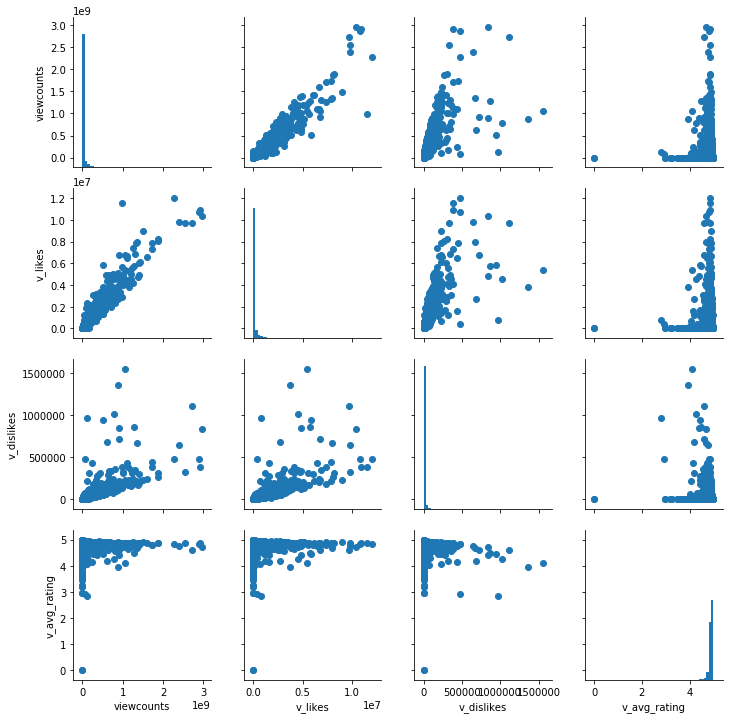

In [16]:
pair_grid = sns.PairGrid(data=df[['viewcounts', 'v_likes', 'v_dislikes', 'v_avg_rating']])
pair_grid.map_offdiag(plt.scatter)
pair_grid.map_diag(plt.hist, bins=50)
plt.show()


### EDA Results
Overall, it can be said that the number of views, the likes and the dislikes appear to be distributed exponentially, which is no big surprise.
Furthermore, likes tend to be higher than the amount of dislikes.   
It is also interesting that there is a big chunk of videos located in the interval of 350k to 13kk views and 
that there are many outliers or extremal points having far higher viewcounts even reaching billions.

## 4: Baseline
Before actually putting our work onto developing a specific model for predicting viewcounts of YouTube videos, 
we wanted to create some baseline to compare the performance of our later models to.  
Therefore, we tried several different things.  
At first we use a K-Nearest-Neighbor regressor with $K=1$ as our most basic predictor.  
In the following figure we want to compare the distribution of the prediction results with the true underlying distribution of the test set. 

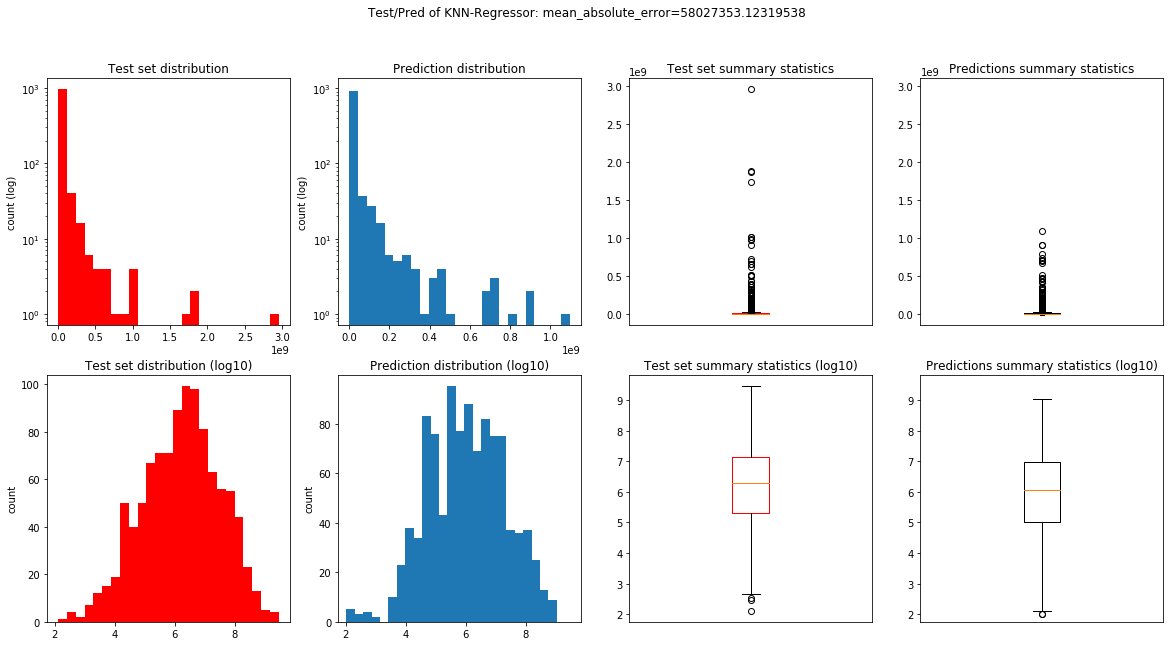

In [17]:
from src.model.baseline import compute_baseline, SimplePredictor
from sklearn.neighbors import KNeighborsRegressor

_ = compute_baseline(KNeighborsRegressor(n_neighbors=1), title='KNN-Regressor')

Please note that we applied log scaling to the y-axis of the two upper left charts in order to make the occurrences of higher viewcounts better visible.  
The two plots below show the distribution of the log transformed response variable viewcounts.  
Due to the high spread between the min and the max viewcount value, 
we decided to apply log transform to our response variable during prediction in general.  
Furthermore, using log transformed responses, we made sure that the response variable are somehow gaussian, which supports some models.   
On the plot, it can be seen that, the prediction distribution overall matches the test distribution.  
However, has a slightly heavier tail on the lower end of the viewcounts, meaning that very high viewcounts are underestimated.  
The boxplots show, how the summary statistics of the predicted viewcounts compares to the summary statistics of the test set.    
On average, the model has a very high mean absolute error of about 53 million views,  
which is possibly due to the fact 
that the prediction distribution is more skewed to the lower viewcount end, 
and of course also due to falsely predicting high viewcount videos as low ones and the other way round.  

As the overall viewcount distribution is very skewed towards the lower end, we also wanted to try out two other baselines.  
Therefore, we use Dummy Regressors predicting constantly just the mean or the median of the train set viewcounts 
completely ignoring the provided features.

The outcome is very interesting, as the overall prediction errors decrease to about 40 million views.  
The median provides a slightly better mean absolute error, 
due to the fact that it is more robust when it comes to outliers.

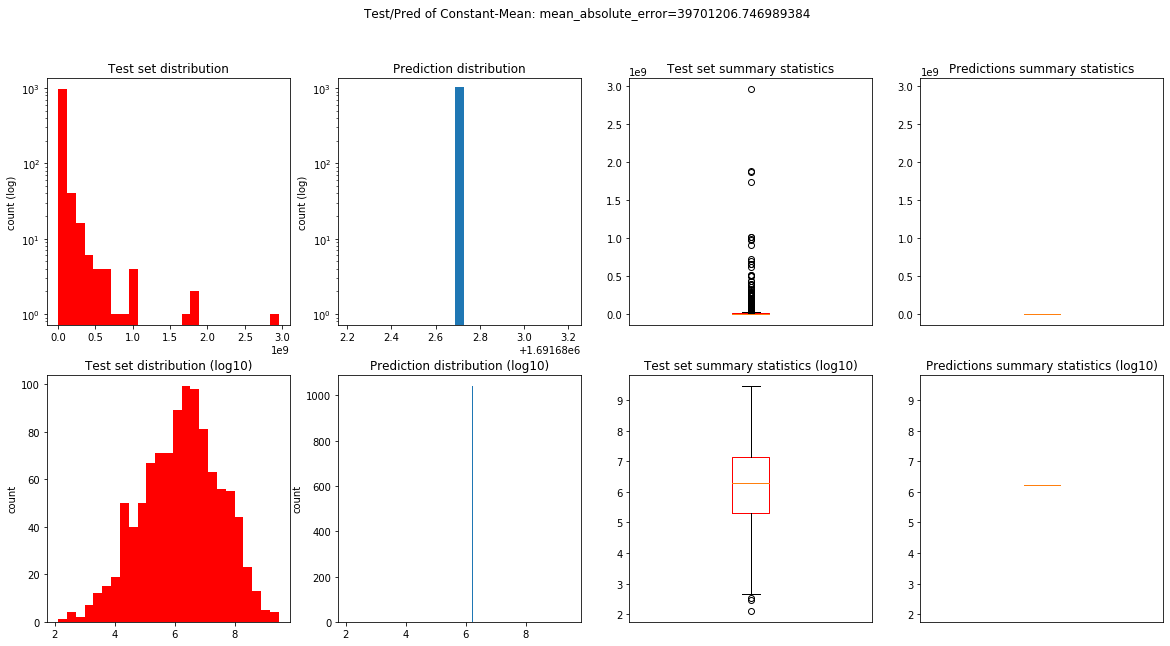

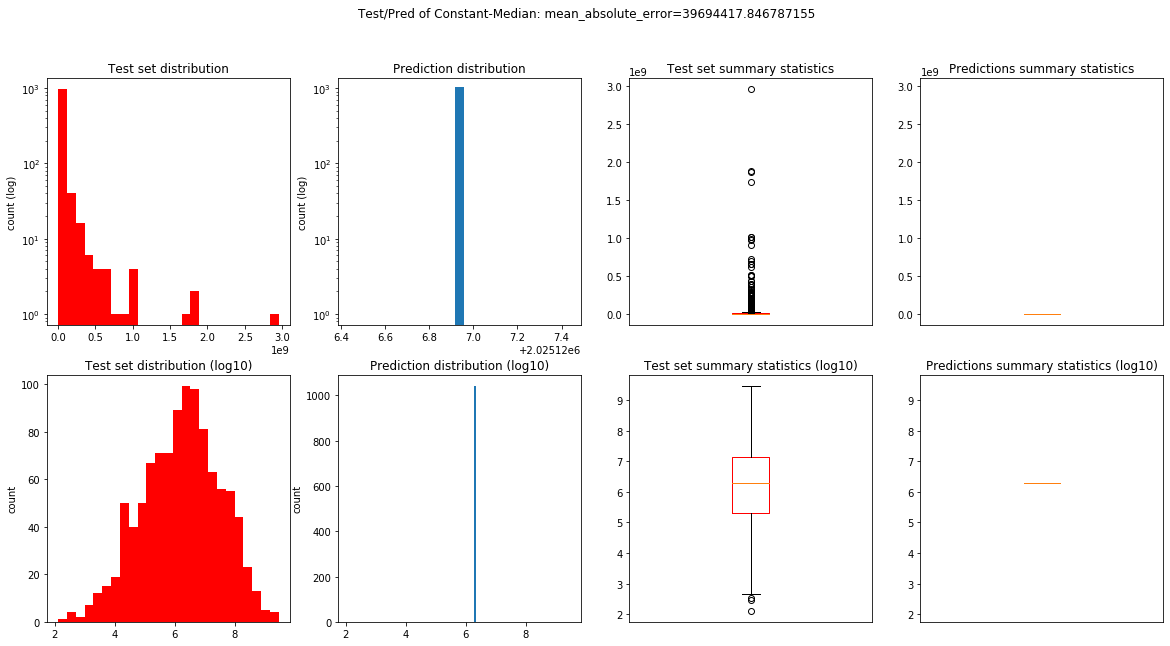

In [18]:
_ = compute_baseline(SimplePredictor(np.mean), title='Constant-Mean')

_ = compute_baseline(SimplePredictor(np.median), title='Constant-Median')

## 5. Model Selection
Based on the defined dataset containing the extracted features mentioned above, we try to beat the baseline results 
using different models.  
In general, we used the following models for regression:
- K-Nearest-Neighbor Regressor
- Random-Forest Regressor
- Support-Vector Regression
- Multi-Layer-Perceptrons

The procedure to find the most suitable model for our data can be described as follows:  
For each model above, we fit the model to the data used to predict the baseline results using the standard model parameters,  
to get a feeling for how the model class performs against the baseline without any parameter tweaking.  
Regarding preprocessing, we only normalize the features using their standard deviation without centering by the mean.  
The target variable is log transformed using the natural logarithm.  

The resulting mean absolute viewcount error is depicted in the following graph as bar chart.  
We excluded the results of the MLP-regressor as it performs by far the worst with a mean absolute error 
of about 5.3 billion views resulting in a negative coefficient of determination of $R^2=-1.18$.  
The other three models perform far better being slightly below 40 Million views concerning their mean absolute error.  
Among them, the SVR has the higherst coefficient of determination with $R^2 = 0.034$,
 which is just slightly better than predicting always the expected value of the viewcounts.  
  
![Basic Model Comparison](./img/error_comparison.png "Basic Model Comparison")

As these results are fairly diminishing we will focus on using our whole feature set in the next steps whilst also 
trying to find the best model parameters.  
Thus, as features we now use the aggregated CNN-feature vectors, the extracted face statistics as well as the color
 vectors which are one-hot encoded as they are categorical features.  
In order to find the best parameters for our models we use our Grid Search Cross Validation Pipeline.  


## 6: Grid Search
For final model selection, we implemented a Grid Search utility, which tries to find the optimal model params, 
using Cross Validation.  
The grid search for a model is employed as follows:
At first, we apply preprocessing to the features and to the response variable.  
Therefore, the features are StandardScaled using their mean and standard deviation.  
Afterwards we apply Principal Component Analysis explaining 95% of the variance, in order to reduce the dimensions 
of our feature vector.  
The response variable (view counts) is log transformed using the natural logarithm. 

Afterwards, the training data is split into 5 folds for Cross Validation and the model is fitted with different parameters. 

The best model configuration is used to compute the mean absolute error on the test set and is stored for later usage.


## 7: Model Performance
This part covers the performance of our models found via our cross validation process.  
Regarding the K Nearest Neighbor regression we found out that the best parameter setting is a neighbor count of 21 
using manhattan distance as distance measure and the inverted distances as variable weights.  
The mean absolute error decreased by about 300k views, however, the $R^2$ score is still negative.

The Support Vector Regressor appears to have one of the best overall results reaching a coefficient of determination 
of $0.11$ and a mean absolute error of 39.49 million views.  
Here we used the RBF-kernel and with an epsilon of $0.01$ as boundary for the $\epsilon$-tube, as well as $C=1$ as 
regularization parameter.  

For Regression using Random Forest cross validation suggested a maximum tree depth of 25 as well as 200 decision 
trees in the ensemble.  
We perform no cost complexity pruning and use 75% of the training samples to train a single tree in the ensemble.  
Regarding the splitting criterion we use the standard variance reduction.  
As a result we obtain a mean absolute viewcount error of about 39.1 Million views and an R2 score of $0.165$,   
which is comparable to the results presented in ["Predicting popularity of online videos 
using Support Vector Regression"](https://ieeexplore.ieee.org/abstract/document/7903630/).  

Compared to the models trained before the parameter search, the MLP-regressor definitely had the highest gain 
performance wise also achieving a mean absolute viewcount error of about 47 Million views now.  
This can be mainly explained by switching from using the ReLu as activation function of the hidden layers to 
the usage of the hyperbolic tangent function.  
However, the results are by far not as good as the results obtained by the usage of the Support Vector Machine or 
the Random Forest Regressor,
 only achieving a mean absolute error of about 47 million views and $R=-0.257$. 
 
In the following we want to summarize our results, with depicting plots comparing the mean absolute errors of 
our trained models as well as their $R^2$ scores.
 

![Final Model Comparison](./img/comparison.png "Final Model Comparison")

## 8:  Conclusion
This work basically is comprised of two major parts.  
The first one being the thorough creation of a YouTube music video dataset, which is a very tedious and complex task as there is a tremendous amount of YouTube videos 
making it very difficult to automatically determine if a found video can be considered as music video.  
Thus, a major issue in this part was to try to avoid false positives in the dataset, which we have successfully restricted to a minimum using our mentioned extraction rules and the application of structural similarity scores.  
The second part of this contribution lies in trying to estimate the amount of views a music video has got, 
solely based on computed visual features.  
Therefore, we implemented a variety of visual feature extraction mechanisms as well as a cross validation pipeline for model evaluation.  
Our best result yields a coefficient of determination of $R^2 = 0.16$, which is, whilst being really low, comparable to the results of others doing research in this domain.  
As a conclusion it can be said, that visual features should only be taken as additional cues to perform popularity estimation 
however definitely not as the only source of information.